In [1]:
import importlib
import warnings

import etrain.dataprocess
import matplotlib_inline
import semetrains
from etrain import ltprocess
from etrain.dataprocess import get_etrains
from etrain.plots import (
    Ylabels,
    plot_cfg,
    plot_hgrid,
    plot_stack,
)
from etrain.utils.axes import CustomIntCategory, CustomRegular

importlib.reload(semetrains)
importlib.reload(etrain.dataprocess)
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")
plot_cfg["watermark_text"] = ""

## Photoionization Inspection

A question that is frequently asked is "where are all the pulses prior to 1ms?"

For that, we can cut down to smaller progenitors to avoid pileup, then look at the timescale from 0-1ms.

Due to limitations with how livetime is calculated and stored, this dataset is recomputed using modified 
livetime axes that enhance resolution at drift-length timescales.

In [2]:
child_dt_lin_s = CustomRegular(
    bins=400,
    start=0,
    stop=0.002,
    label="$\\Delta$t [s]",
    name="child_dt_s",
    title_label="Time Since Progenitor",
)

In [3]:
ltprocess.livetime_axes["lin"] = child_dt_lin_s

In [4]:
# Recomupting livetime is generally pretty expensive
ltprocess.main(
    file="/home/emiz/projects/projectdata/sv_SEdecaytime/BigDEB_4.0_6726-6762"
)

Starting Dask...
Wrote out /home/emiz/projects/projectdata/sv_SEdecaytime/BigDEB_4.0_6726-6762/prog_pulses.parquet
Wrote out /home/emiz/projects/projectdata/sv_SEdecaytime/BigDEB_4.0_6726-6762/child_pulses.parquet


In [4]:
prog_cols = [
    "prog_tpc_region",
    "prog_drift_time_ms",  # for normalization
    "prog_area_se_r",  # for S2 normalizations
    "log_lt",  # loggified livetime
    "lin_lt",
]
prog_names = [name for name in prog_cols if "prog_" in name]
child_cols = [
    "child_dt_s",
    "child_dr_cm",
    "child_dr_weight",
    "child_area_se_cat",
    "child_area_phd",
    "child_pcorr",
    "child_classification",
] + prog_names

In [5]:
f_acc = "/home/emiz/projects/projectdata/sv_SEdecaytime/BigDEB_4.0_6726-6762"

data_acc = get_etrains(
    f_acc,
    prog_columns=prog_cols,
    child_columns=child_cols,
).prog_filter("prog_tpc_region", "ne", 0)  # exclude gas events

etrains = data_acc.child_filter("child_classification", "eq", 0).concat_children(
    data_acc.child_filter("child_classification", "eq", 1)
)  # SE and S2 pulses

In [6]:
child_classification = CustomIntCategory(
    categories=[0, 1],
    label="Child Classification",
    name="child_classification",
    cat_labels={0j: "SE", 1j: "S2"},
)

# Manually override the default axis. Could be refactored at some point.
etrains.axes.child_dt_lin_s = child_dt_lin_s
etrains.axes.child_classification = child_classification

In [7]:
y_label = Ylabels().get_label(["rate", "child_dr_cm"])

h_counts = etrains.get_counts_hist(
    [
        "child_dt_lin_s",
        "child_pcorr",
        "prog_area_se_r",
        "prog_drift_time_ms",
        "child_classification",
    ],
    "child",
    weight=etrains.child_pulses.child_dr_weight,
)

h_lt = etrains.get_nd_lt_hist(["prog_area_se_r", "prog_drift_time_ms"], lt_type="lin")

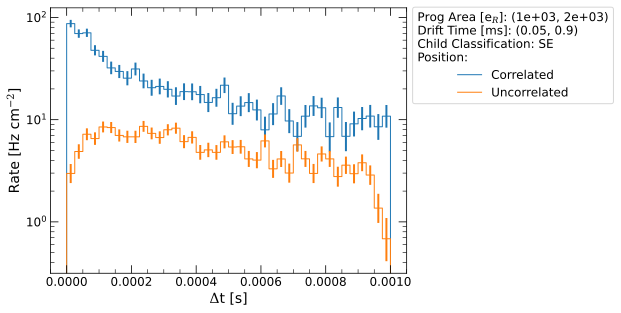

In [9]:
# | label: photoion-check

stack_axis = "child_pcorr"
x_axis = "child_dt_lin_s"

cut_dict = dict(
    prog_drift_time_ms=slice(0.05j, 0.95j, sum),
    prog_area_se_r=slice(1000j, 2000j, sum),
    child_classification="SE",
)

stack = etrains.make_rate_stack(
    h_counts,
    h_lt,
    stack_axis,
    x_axis,
    slice_x=slice(0j, 0.001j, 5j),
    cut_dict=cut_dict,
)

fig, axes = plot_stack(
    stack,
    ylabel=y_label,
    leg_kwargs=dict(loc="upper left", bbox_to_anchor=(1, 1.025)),
)

In [8]:
y_label = Ylabels().get_label(["rate", "child_dr_cm"])

h_counts = etrains.get_counts_hist(
    [
        "child_dt_log_s",
        "child_pcorr",
        "prog_area_se_r",
        "prog_drift_time_ms",
        "child_classification",
    ],
    "child",
    weight=etrains.child_pulses.child_dr_weight,
)

h_lt = etrains.get_nd_lt_hist(["prog_area_se_r", "prog_drift_time_ms"], lt_type="log")

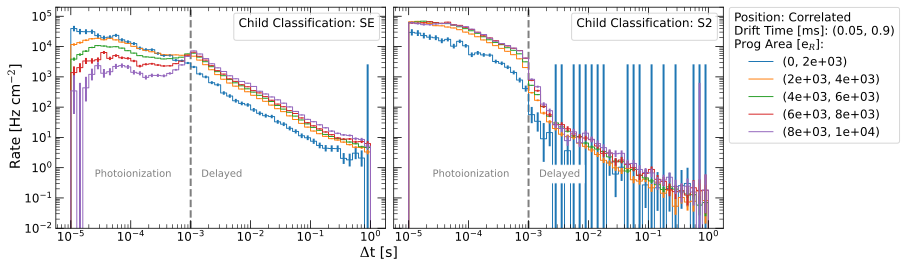

In [12]:
# | label: photoion-check-prog-area-stack

grid_axis = "child_classification"
stack_axis = "prog_area_se_r"
x_axis = "child_dt_log_s"

cut_dict = dict(
    prog_drift_time_ms=slice(0.05j, 0.95j, sum),
    child_pcorr="Correlated",
    child_classification="SE",
)

stack_labels = etrains.get_axis(grid_axis).get_cat_labels()
stacks = []
for label in stack_labels:
    cut_dict[grid_axis] = label
    stack = etrains.make_rate_stack(
        h_counts,
        h_lt,
        stack_axis,
        x_axis,
        slice_x=slice(0j, 1j, 2j),
        cut_dict=cut_dict,
    )
    stack.name = f"{etrains.get_axis(grid_axis).label}: {stack.cuts_applied.pop(etrains.get_axis(grid_axis).label)}"
    stacks.append(stack)

fig, axes = plot_hgrid(
    stacks,
    supylabel=y_label,
    ylim=(1e-2, 2e5),
)

for ax in axes:
    ax.axvline(x=1e-3, color="tab:gray", zorder=0, linestyle="--")
    ax.text(x=2.5e-5, y=5e-1, s="Photoionization", color="tab:gray")
    ax.text(x=1.5e-3, y=5e-1, s="Delayed", color="tab:gray", backgroundcolor="white")

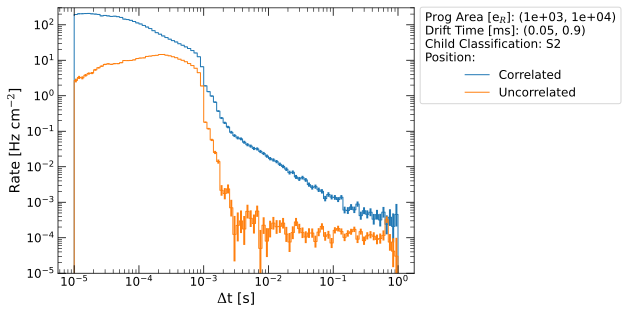

In [12]:
# | label: photoion-check-log-S2

stack_axis = "child_pcorr"
x_axis = "child_dt_log_s"

cut_dict = dict(
    prog_drift_time_ms=slice(0.05j, 0.95j, sum),
    prog_area_se_r=slice(1000j, 10000j, sum),
    child_classification="S2",
)

stack = etrains.make_rate_stack(
    h_counts,
    h_lt,
    stack_axis,
    x_axis,
    slice_x=slice(0j, 1j, 1j),
    cut_dict=cut_dict,
)

fig, axes = plot_stack(
    stack,
    ylabel=y_label,
    leg_kwargs=dict(loc="upper left", bbox_to_anchor=(1, 1.025)),
    ax_kwargs=dict(ylim=(1e-5, 3e2)),
)